In [3]:
#1 cell
from IPython.display import Image, display


In [4]:
#2nd cell
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion of color space
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time

ModuleNotFoundError: No module named 'torch'

In [ ]:
# Check if GPU is available
#3rd cell
use_gpu = torch.cuda.is_available()

In [ ]:
#4th cell
class ColorizationNet(nn.Module):
    def __init__(self, input_size=128):
        super(ColorizationNet, self).__init__()
        MIDLEVEL_FEATURE_SIZE = 128

        # Convolutional part of the model
        resnet = models.resnet18(num_classes=365) 
        # Change first conv layer to accept single-channel (grayscale) input
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
        # Extract midlevel features from ResNet-gray
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

        #DeonvolutionaL PART OF CODE
        self.upsample = nn.Sequential(     
          nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
          nn.Upsample(scale_factor=2)
        )

    def forward(self, input):
        # Pass input GRAY CHANNEL THROUGH CONVOLUTIONAL PART 
        midlevel_features = self.midlevel_resnet(input)
        
        # DECONVOLUTIONAL PART
        output = self.upsample(midlevel_features)
        return output

In [ ]:
#5th cell
model = ColorizationNet()

In [ ]:
#6th cell
criterion = nn.MSELoss()

In [ ]:
#7th cell
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

In [ ]:
#FUNCTION TO GET GrAYSCALE AND AB CHANNEL
#8th cell
class GrayscaleImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img_original = self.transform(img)
            img_original = np.asarray(img_original)
            img_lab = rgb2lab(img_original)
            img_lab = (img_lab + 128) / 255
            img_ab = img_lab[:, :, 1:3]
            img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
            img_original = rgb2gray(img_original)
            img_original = torch.from_numpy(img_original).unsqueeze(0).float()
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img_original, img_ab, target

In [ ]:
# Training
#9th cell
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('F:/mtech/color/images/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder,batch_size=64,shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('F:/mtech/color/images/val' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

In [ ]:
#10th cell
class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
#LAB TO RGB
def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
    plt.clf() # clear matplotlib 
    color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
    color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
    color_image = lab2rgb(color_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()
    if save_path is not None and save_name is not None: 
        plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
        plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [ ]:
#11th cell
def validate(val_loader, model, criterion, save_images, epoch):
    model.eval()

  # Prepare value counters and timers
    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()
    already_saved_images = False
    for i, (input_gray, input_ab, target) in enumerate(val_loader):
        data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: 
        input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
        already_saved_images = True
        for j in range(min(len(output_ab), 10)): # save at most 5 images
            save_path = {'grayscale': 'F:/mtech/output/gray/', 'colorized':'F:/mtech/output/color/'}
            save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
            to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
        print('Validate: [{0}/{1}]\t'
              'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(i, len(val_loader), batch_time=batch_time, loss=losses))

        print('Finished validation.')
    return losses.avg

In [ ]:
#PROGRAM FOR TRAINING
#12th cell
def train(train_loader, model, criterion, optimizer, epoch):
    print('Starting training epoch {}'.format(epoch))
    model.train()

    # Prepare value counters and timers
    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()
    for i, (input_gray, input_ab, target) in enumerate(train_loader):

    # Use GPU if available
        if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
        data_time.update(time.time() - end)

    # Run forward pass
        output_ab = model(input_gray) 
        loss = criterion(output_ab, input_ab) 
        losses.update(loss.item(), input_gray.size(0))

        # Compute gradient and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record time to do forward and backward passes
        batch_time.update(time.time() - end)
        end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
        if i % 25 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses)) 

    print('Finished training epoch {}'.format(epoch))

In [ ]:
# Move model and loss function to GPU
#13th cell
if use_gpu: 
    criterion = criterion.cuda()
    model = model.cuda()

In [ ]:
# Make folders and set parameters
#14th cell
import os
os.makedirs('F:/mtech/output/color/', exist_ok=True)
os.makedirs('F:/mtech/output/gray/', exist_ok=True)
os.makedirs('F:/mtech/output/checkpoint/', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 30

In [ ]:
# Train model
#15th cell
for epoch in range(epochs):
    # Train for one epoch, then validate
    train(train_loader, model, criterion, optimizer, epoch)
    with torch.no_grad():
        losses = validate(val_loader, model, criterion, save_images, epoch)
    # Save checkpoint and replace old best model if current model is better
    if losses < best_losses:
        best_losses = losses
        torch.save(model.state_dict(), 'F:/mtech/output/checkpoint/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

In [ ]:
# Load model
#16th cell
pretrained = torch.load('F:/mtech/output/checkpoint/model-epoch-21-losses-0.003.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(pretrained)

<All keys matched successfully>

In [ ]:
# Validate
#17th cell
save_images = True
with torch.no_grad():
    validate(val_loader, model, criterion, save_images, 1)

Validate: [0/1]	Time 1.925 (1.925)	Loss 0.0016 (0.0016)	
Finished validation.


<Figure size 432x288 with 0 Axes>

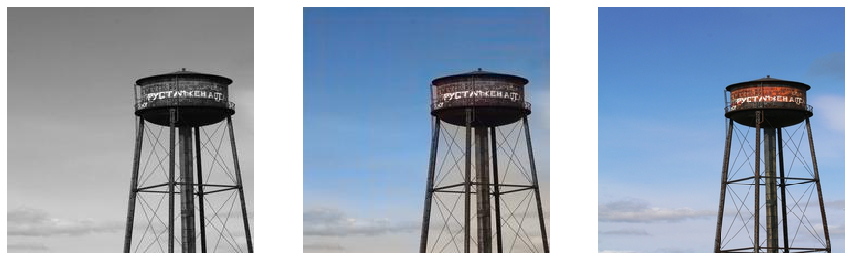

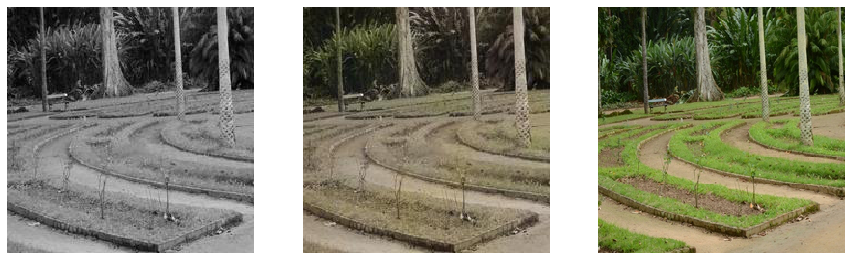

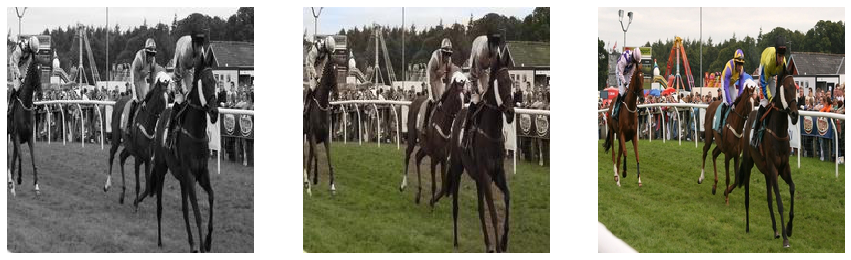

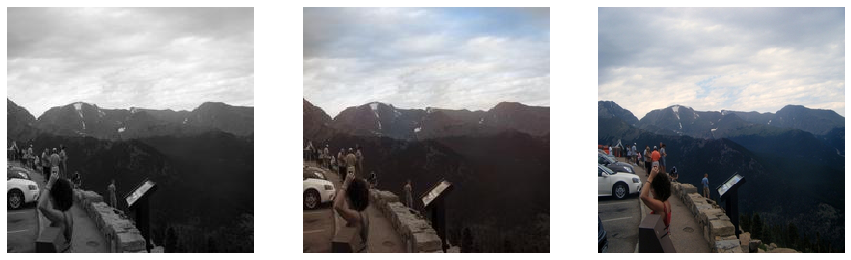

In [ ]:
# Show images 
#18th cell
import numpy
import matplotlib.image as mpimg
image_pairs = [('F:/mtech/output/color/img-1-epoch-1.jpg', 'F:/mtech/output/gray/img-1-epoch-1.jpg','F:/mtech/color/images/val/class/00000002.jpg'),
              ('F:/mtech/output/color/img-0-epoch-1.jpg', 'F:/mtech/output/gray/img-0-epoch-1.jpg','F:/mtech/color/images/val/class/00000001.jpg')
               ,('F:/mtech/output/color/img-3-epoch-1.jpg', 'F:/mtech/output/gray/img-3-epoch-1.jpg','F:/mtech/color/images/val/class/00000006.jpg')
              ,('F:/mtech/output/color/img-2-epoch-1.jpg', 'F:/mtech/output/gray/img-2-epoch-1.jpg','F:/mtech/color/images/val/class/00000003.jpg')]
              
for c,g,g1 in image_pairs:
    color = mpimg.imread(c)
    gray  = mpimg.imread(g)
    gt    = mpimg.imread(g1)
    f, axarr = plt.subplots(1, 3)
    f.set_size_inches(15, 15)
    axarr[0].imshow(gray, cmap='gray')
    axarr[1].imshow(color)
    axarr[2].imshow(gt)
    
    axarr[0].axis('off'), axarr[1].axis('off'),axarr[2].axis('off')
    plt.show()